In [1]:
# -----------------------------
# 1. Libraries & Spark session
# -----------------------------
from pyspark.sql import Row
import numpy as np
import cv2
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, FloatType
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

wsl_ip = "172.27.235.9"  # WSL IP

spark = SparkSession.builder \
    .appName("Pneumonia X-ray Preprocessing") \
    .master("local[*]") \
    .config("spark.hadoop.fs.defaultFS", f"hdfs://{wsl_ip}:9000") \
    .config("spark.driver.host", "127.0.0.1") \
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "6g") \
    .config("spark.default.parallelism", "2") \
    .config("spark.sql.shuffle.partitions", "2") \
    .getOrCreate()

sc = spark.sparkContext

25/05/09 02:54:44 WARN Utils: Your hostname, DESKTOP-EK3V8PF resolves to a loopback address: 127.0.1.1; using 172.27.235.9 instead (on interface eth0)
25/05/09 02:54:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/09 02:54:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
spark

In [3]:
# -----------------------------
# 2. Image Decoder + Label
# -----------------------------
def process_image(path_content):
    path, content = path_content
    try:
        np_img = np.frombuffer(content, dtype=np.uint8)
        img = cv2.imdecode(np_img, cv2.IMREAD_GRAYSCALE)
        if img is None:
            return None
        img_resized = cv2.resize(img, (64, 64))
        img_normalized = img_resized.astype(np.float32) / 255.0
        label = path.split("/")[-2]
        return Row(path=path, label=label, image=img_normalized.tolist())
    except Exception:
        return None

In [7]:
# -----------------------------
# 3. Load and Process Images
# -----------------------------
binary_rdd = sc.binaryFiles(f"hdfs://{wsl_ip}:9000/data/pneumonia_dataset/*/*.jpg")
processed_rdd = binary_rdd.map(process_image).filter(lambda x: x is not None)
image_df = spark.createDataFrame(processed_rdd)

In [8]:
# -----------------------------
# 4. Flatten Images for ML
# -----------------------------
def flatten_to_vector(image):
    return Vectors.dense([pixel for row in image for pixel in row])

flatten_udf = udf(flatten_to_vector, VectorUDT())
image_df = image_df.withColumn("features", flatten_udf("image"))

In [10]:
# -----------------------------
# 6. ML Pipeline: Multiclass Logistic Regression
# -----------------------------
label_indexer = StringIndexer(inputCol="label", outputCol="label_index")
logreg = LogisticRegression(labelCol="label_index", featuresCol="features", maxIter=20)
pipeline = Pipeline(stages=[label_indexer, logreg])

train_df, test_df = image_df.randomSplit([0.8, 0.2], seed=42)
svm_model = pipeline.fit(train_df)
predictions = svm_model.transform(test_df)

25/05/09 03:04:11 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
                                                                                

In [8]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# 1. Evaluate Accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="label_index", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy:.4f}")

# 2. Evaluate F1-Score
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="label_index", predictionCol="prediction", metricName="f1")
f1 = f1_evaluator.evaluate(predictions)
print(f"F1 Score: {f1:.4f}")

# 3. Precision
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="label_index", predictionCol="prediction", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(predictions)
print(f"Precision: {precision:.4f}")

# 4. Recall
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="label_index", predictionCol="prediction", metricName="weightedRecall")
recall = recall_evaluator.evaluate(predictions)
print(f"Recall: {recall:.4f}")


Accuracy: 0.8125


F1 Score: 0.8046


Precision: 0.8031


[Stage 56:==================================================>     (27 + 3) / 30]

Recall: 0.8125


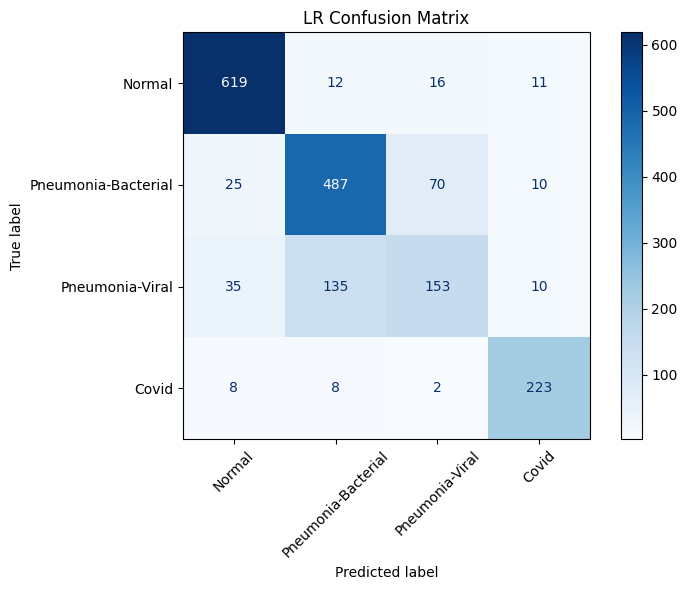

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Collect predictions
preds_df = predictions.select("label_index", "prediction").toPandas()

# Compute confusion matrix
cm = confusion_matrix(preds_df["label_index"], preds_df["prediction"])

# Define class labels in the correct index order
class_names = ["Normal", "Pneumonia-Bacterial", "Pneumonia-Viral", "Covid"]

# Display confusion matrix with custom labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("LR Confusion Matrix")
plt.tight_layout()
plt.show()

In [13]:
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions and labels
preds_df = predictions.select("label_index", "prediction").toPandas()

# Create report
report = classification_report(
    preds_df["label_index"],
    preds_df["prediction"],
    output_dict=True
)

# Convert to DataFrame
report_df = pd.DataFrame(report).transpose()

# Filter only the class rows (0, 1, 2, 3)
class_metrics = report_df.iloc[:4][["precision", "recall", "f1-score"]]
class_metrics.index = ["Normal", "Pneumonia-Bacterial", "Pneumo-Viral", "Covid"]

display(class_metrics.style.format("{:.3f}").set_caption("Per-Class Evaluation Metrics"))

,precision,recall,f1-score
Normal,0.892,0.934,0.912
Pneumonia-Bacterial,0.727,0.786,0.756
Pneumo-Viral,0.556,0.415,0.475
Covid,0.898,0.926,0.912


In [14]:
spark.stop()